In [1]:
import statsmodels
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.tsa.holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import median_absolute_error
from sklearn.utils import check_array
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime

from python.test_preprocessing import preprocess_data, save_json, test_kwargs
%matplotlib inline
plt.style.use('Solarize_Light2')

Мы создадим тестовые json файлы для предобработанных 4 датасетов из бенчмарков.

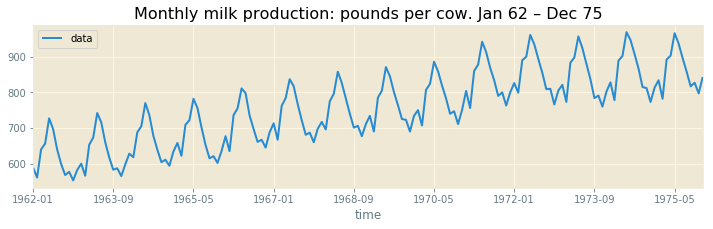

In [2]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22ox')
jobj = json.loads(r.text[18:-1])
data = jobj[0]['data']
df = pd.DataFrame(data, columns=['time','data']).set_index('time')
train = df.iloc[:-24, :]
test = df.iloc[-24:, :]
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3));
plt.title(jobj[0]['title'])
df.index =  pd.to_datetime(df.index);

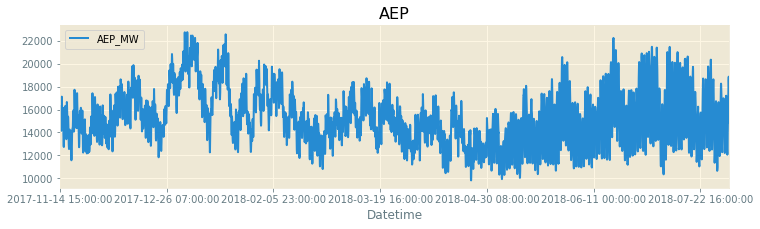

In [3]:
data_aep = pd.read_csv('./test_dfs/AEP_hourly.csv')
aep = pd.DataFrame(data_aep, columns=['Datetime','AEP_MW']).set_index('Datetime')
aep.sort_index(inplace=True) 
aep = aep.iloc[115000:] 
train_aep = aep.iloc[:-100, :]
test_aep = aep.iloc[-100:, :]
train_aep.index = pd.to_datetime(train_aep.index)
test_aep.index = pd.to_datetime(test_aep.index)
pred_aep = test_aep.copy()
aep.plot(figsize=(12,3));
plt.title('AEP')
aep.index =  pd.to_datetime(aep.index);

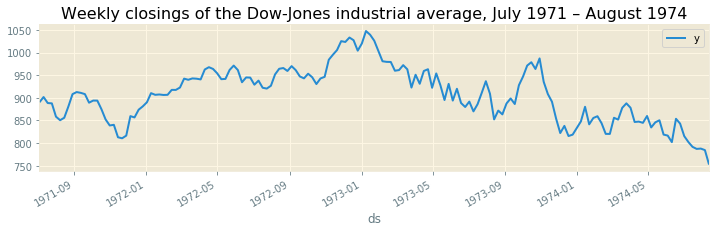

In [4]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22yw')
jobj_dj = json.loads(r.text[18:-1])
data_dj = pd.DataFrame(jobj_dj[0]['data'], columns=['ds_','y'])
data_dj['ds'] = data_dj.reset_index().apply(lambda row: datetime.datetime.strptime(str(row['ds_']) + '-1', "%Y-W%W-%w"), axis=1)
data_dj = data_dj.drop(['ds_'], axis=1)
df_dj = data_dj.set_index('ds')
train_dj = df_dj.iloc[:-14, :]
test_dj = df_dj.iloc[-14:, :]
train_dj.index = pd.to_datetime(train_dj.index)
test_dj.index = pd.to_datetime(test_dj.index)
df_dj.plot(figsize=(12,3));
plt.title(jobj_dj[0]['title'])
df_dj.index =  pd.to_datetime(df_dj.index);

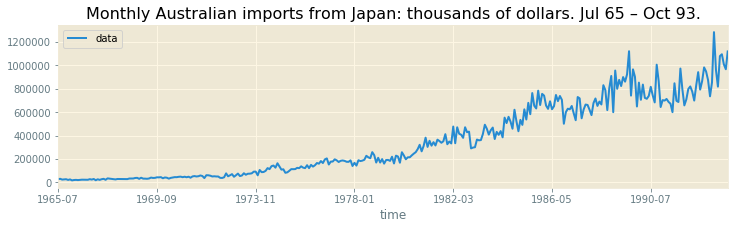

In [5]:
r = requests.get('https://datamarket.com/api/v1/list.json?ds=22qx')
jobj_au = json.loads(r.text[18:-1])
data_au = jobj_au[0]['data']
df_au = pd.DataFrame(data_au, columns=['time','data']).set_index('time')
train_au = df_au.iloc[:-12, :]
test_au = df_au.iloc[-12:, :]
pred_au = test_au.copy()
df_au.plot(figsize=(12,3));
plt.title(jobj_au[0]['title'])
df_au.index =  pd.to_datetime(df_au.index);

In [6]:
for data in [train, train_aep, train_dj, train_au]:
    data.reset_index(inplace=True)
    data.columns = ["ds", "y"]

In [7]:
dat_milk, init_milk = preprocess_data(train)
save_json(dat_milk, "./tests_json/milk.data.json")
save_json(init_milk, "./tests_json/milk_init.json")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2014-01-01','2015-01-01','2016-01-01', '2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2016-01-18', '2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2016-02-15', '2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2016-05-30', '2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2014-07-04','2015-07-04', '2016-07-04', '2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2015-09-07', '2016-09-05', '2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2015-10-12', '2016-10-10', '2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2014-11-11','2015-11-11', '2016-11-11', '2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2015-11-26', '2016-11-24'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2014-12-25','2015-12-25', '2016-12-25','2017-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

dat_aep, init_aep = preprocess_data(train_aep, test_kwargs_change={"yearly_seasonality": True,
                                                                   "weekly_seasonality": True,
                                                                   "holidays": us_public_holidays})
save_json(dat_aep, "./tests_json/aep.data.json")
save_json(init_aep, "./tests_json/aep_init.json")

In [9]:
dat_dj, init_dj = preprocess_data(train_dj, test_kwargs_change={"yearly_seasonality": True,
                                                                 "weekly_seasonality": True,
                                                                 "holidays": us_public_holidays})
save_json(dat_dj, "./tests_json/dj.data.json")
save_json(init_dj, "./tests_json/dj_init.json")

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
dat_au, init_au = preprocess_data(train, test_kwargs_change={"yearly_seasonality": True,
                                                             "seasonality_mode": "multiplicative"})
save_json(dat_au, "./tests_json/au.data.json")
save_json(init_au, "./tests_json/au_init.json")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
